In [ ]:
!pip3 install torch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 
from torch.utils.data import TensorDataset

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import random
import math

# Q1 gradient descent로 simple linear regression 추정하기

예제로 사용할 데이터 생성하기

$ y_i = \beta_0 + \beta_1 \times x_i + \epsilon_i \quad \epsilon_i \sim  iid N(0, 1)$ 

$ \beta_0 = 5, \beta_1 = 2$라는 모형을 따르는 데이터를 생성해준다. 

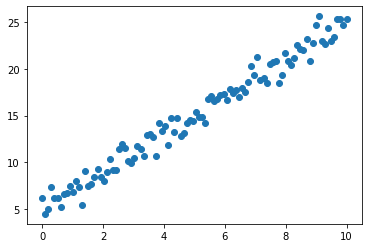

In [ ]:
x_train_np = np.linspace(0, 10, 100).reshape(-1, 1)
y_train_np = 2 *  x_train_np + 5 + norm.rvs(0, 1, size = len(x_train_np)).reshape(-1, 1)

plt.scatter(x_train_np, y_train_np)
plt.show()

$ \hat{y_i} = \beta_0 + \beta_1 \times x_i $

$ \hat{y_i} = bias + weight \times x_i $

gradient descent를 사용해 bias와 weight를 학습해보자. 

1) 추정된 bias와 weight의 결과값은 얼마인가? 그래프를 그려 실제 회귀식에 가깝게 추정되었는지를 확인해보자. 

In [ ]:
x_train = torch.FloatTensor(x_train_np)
y_train = torch.FloatTensor(y_train_np)

W = torch.zeros(1, requires_grad = True) # Weight
b = torch.zeros(1, requires_grad = True) # bias

optimizer = optim.SGD([W, b], lr = 0.01)

n_epochs = 1000
for epoch in range(n_epochs + 1):

  # H(x) 계산
  hypothesis = # your code here
  
  # cost 계산: MSE
  cost = # your code here

  # cost로 H(x) 개선
  # your code here

  if epoch % 100 == 0:
      print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
          epoch, n_epochs, W.item(), b.item(), cost.item()
      ))

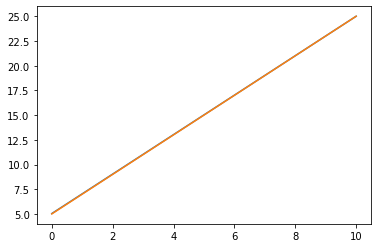

In [ ]:
y_pred = W * x_train + b # 추정한 회귀식
y_real = 2 * x_train + 5 # 실제 회귀식

plt.plot(x_train_np, y_pred.detach().numpy())
plt.plot(x_train_np, y_real.detach().numpy())

2) learning rate를 0.03으로 조정해보자. 어떠한 문제가 발생하는가?

답: cost(MSE)가 최소가 되는 점을 찾지 못하고 발산한다. 

In [ ]:
# 직접 W와 b를 정의하지 않고, nn.Module을 사용해 손쉽게 선형 모델을 생성할 수 있습니다. 
# 입출력값의 차원을 생각해 in_features와 out_features의 값을 적절하게 지정해주세요

in_features = # your code here
out_features = # your code here

model = nn.Linear(in_features = in_features, out_features = out_features, bias = True)

optimizer = optim.SGD(model.parameters(), lr = 0.03)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = model(x_train)
    
    # cost 계산
    cost = F.mse_loss(hypothesis, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        params = list(model.parameters())
        W = params[0].item()
        b = params[1].item()
        print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
            epoch, nb_epochs, W, b, cost.item()
        ))

3) learning rate를 0.00000001로 조정해보자. 어떠한 문제가 발생하는가?

답: cost가 최소가 되는 점을 찾기까지 시간이 오래걸린다. epoch수를 늘리면 찾을수도 있지만 비효율적이다. 

In [ ]:
W = torch.zeros(1, requires_grad = True) # Weight
b = torch.zeros(1, requires_grad = True) # bias

optimizer = optim.SGD([W, b], lr = 0.00000001)

n_epochs = 1000
for epoch in range(n_epochs + 1):

  # H(x) 계산
  hypothesis = x_train * W + b 
  
  # cost 계산: MSE
  cost = torch.mean((hypothesis - y_train)**2) 

  # cost로 H(x) 개선
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
      print('Epoch {:4d}/{} W: {:.3f}, b: {:.3f} Cost: {:.6f}'.format(
          epoch, nb_epochs, W.item(), b.item(), cost.item()
      ))

Epoch    0/1000 W: 0.000, b: 0.000 Cost: 260.390045
Epoch  100/1000 W: 0.000, b: 0.000 Cost: 260.355286
Epoch  200/1000 W: 0.000, b: 0.000 Cost: 260.320435
Epoch  300/1000 W: 0.001, b: 0.000 Cost: 260.285675
Epoch  400/1000 W: 0.001, b: 0.000 Cost: 260.250885
Epoch  500/1000 W: 0.001, b: 0.000 Cost: 260.216064
Epoch  600/1000 W: 0.001, b: 0.000 Cost: 260.181274
Epoch  700/1000 W: 0.001, b: 0.000 Cost: 260.146545
Epoch  800/1000 W: 0.001, b: 0.000 Cost: 260.111786
Epoch  900/1000 W: 0.002, b: 0.000 Cost: 260.076965
Epoch 1000/1000 W: 0.002, b: 0.000 Cost: 260.042236


# Q2. train set and test set - MNIST

MNIST dataset을 불러온다. 

In [ ]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

data_loader = DataLoader(dataset = mnist_train,
                         batch_size = 100, 
                         shuffle = True
                         )

1) epoch 수를 15로 설정하여 trainset을 훈련시켜보자. 

그 후 훈련시킨 모델로 testset에 대한 평가를 진행해보자. 

In [ ]:
# train model with train sets

# 입출력값의 차원을 생각해 in_features와 out_features의 값을 적절하게 지정해주세요

in_features = # your code here
out_features = # your code here
linear = torch.nn.Linear(in_features = in_features, out_features=out_features, bias = True)

criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

training_epochs = 15

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28)
        Y = Y

        # H(x) 계산
        hypothesis = linear(X)

        # cost 계산
        cost = criterion(hypothesis, Y)

        #cost로 H(x) 개선
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

In [ ]:
# Test the model using test sets
with torch.no_grad(): # torch.no_grad()를 사용하는 이유를 간단하게 설명해봅시다. 

    X_test = mnist_test.test_data.view(-1, 28 * 28).float()
    Y_test = mnist_test.test_labels

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
    print('cost:', cost.item())

2) epoch 수를 30으로 설정하여 trainset을 훈련시켜보자. 

그 후 훈련시킨 모델로 testset에 대한 평가를 진행해보자. 

어떠한 문제가 발생하는가?

In [ ]:
linear = torch.nn.Linear(784, 10, bias = True)
criterion = torch.nn.CrossEntropyLoss()   
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

training_epochs = 30

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        X = X.view(-1, 28 * 28)
        Y = Y

        # H(x) 계산
        hypothesis = linear(X)

        # cost 계산
        cost = criterion(hypothesis, Y)

        #cost로 H(x) 개선
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    if epoch % 5 == 0:
      print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

In [ ]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float()
    Y_test = mnist_test.test_labels

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    
    print('Accuracy:', accuracy.item())
    print('cost:', cost.item())

# Q3. XOR problem with multilayer perceptron



In [ ]:
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = torch.FloatTensor([[0], [1], [0], [1]])

# 입출력값의 차원을 고려하여 아래 빈칸을 적절하게 채워주세요
linear1 = torch.nn.Linear('', '', bias = True)
linear2 = torch.nn.Linear('', '', bias = True)
sigmoid = torch.nn.Sigmoid()

# 딥러닝의 구조를 고려하여 multi perceptron 모델을 적절하게 생성하세요. 
# nn.Sequential 함수를 사용하세요
model =  # your code here

# 이 예제에서 cross entropy 대신 BCE를 사용하는 이유를 간단하게 설명하세요
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 1)

for step in range(301):
  hypothesis = model(X)
  cost = criterion(hypothesis, Y)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()
  if step%50 == 0:
    print(step, cost.item())

##Q4. Sine Function Approximation using the Legendre *Polynomial*

n = 3일때 르장드르 다항식은 다음과 같다. \
$ P_{3} = \frac{1}{2} (5x^{3} -3x) $ \
이 함수를 사용하여, sine함수를 근사하도록 학습하려고 한다.


1) Forward, Backward 함수를 직접 작성하여보자.

In [ ]:
# 이 클래스에서, forward, backward 함수가 하는 기능이 무엇인지 설명해주세요.

class Legendre3Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return grad_output * 'your code here'
        # Hint : Legendre Polynomial의 differential

2) 학습을 위한 parameter와 Data를 세팅해보자.
   우리가 사용하려는 모델은 다음과 같다.\
   $ y = a + b * P_{3}(c + d * x) $

In [ ]:
dtype = torch.float
device = torch.device("cpu")

x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x) # Target function to approximate

# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

3) 1)에서 정의한 forward, backward 함수를 사용하여,
   딥러닝 학습 과정을 직접 작성해보자.\
   \
   Learning rate의 경우, 5e-2, 5e-4, 5e-6, 5e-8 중,
   가장 적절한 Learning rate를 찾아보자. \
   적절한 learning rate보다 learning rate가 크거나 작을 때,
   어떤 현상이 발생하는지 살펴보자.

In [ ]:
# [5e-2, 5e-4, 5e-6, 5e-8] 중 적절한 learning rate를 찾아주세요.
# 적절한 learning rate보다 learning rate가 크거나 작을 때, 어떤 차이가 생기는지
# 말씀해주세요.
learning_rate = 'your code here'

# epoch = 2000
for t in range(2000):
    P3 = Legendre3Function.apply

    # Forward pass: predict y.
    # P3 using our custom backward function.
    y_pred = 'your code here'

    # Compute and print MSE loss
    loss = 'your code here'
    if t % 100 == 0:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    'your code here'

    # Update weights using gradient descent
    # Hint : use a, b, c, d, learning_rate, a.grad, b.grad, c.grad, d.grad
    with torch.no_grad():
        'your code here'

        # Manually zero the gradients after updating weights
        'your code here'

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

##Q5. Different Basis Function for approximating sine function

이번에는 ReLu function을 사용하여 sine함수를 학습해보려 한다. \
ReLu function을 사용했을 때에도, 학습이 잘 되는지 살펴보자.

In [ ]:
class ReLuFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return 'your code here'

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        'your code here'
        # Hint : reLu function의 도함수의 형태를 반영하면 됩니다.
        return grad_input

dtype = torch.float
device = torch.device("cpu")

x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = 'your code here'

# Our model : y = a + b * ReLu(c + d * x).
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), 1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 1.0, device=device, dtype=dtype, requires_grad=True)

learning_rate = 5e-7
for t in range(2000):
    ReLu = ReLuFunction.apply

    # Forward pass: predict y.
    # ReLu using our custom backward function.
    y_pred = 'your code here'

    # Compute and print MSE loss
    loss = 'your code here'
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    'your code here'

    # Update weights using gradient descent
    # Hint : use a, b, c, d, learning_rate, a.grad, b.grad, c.grad, d.grad
    with torch.no_grad():
        'your code here'

        # Manually zero the gradients after updating weights
        'your code here'

print(f'Result: y = {a.item()} + {b.item()} * ReLu({c.item()} + {d.item()} x)')

## Q6. 
Q4, Q5에서 학습한 결과를 바탕으로, 어떤 function을 사용하는 것이 학습에 더 적절했었는지 코멘트해주세요.

## Q7. Deep Learning Example

주어진 데이터를 로딩하고, 아래 코드의 빈칸을 채워
딥러닝 학습을 하는 코드를 완성하여보자.

In [ ]:
# 업로드 시간이 7분 30초 가량 걸리기에, 그동안 밑에 코드 작성 먼저 해주셔도 됩니다. (colab 사용시)
# colab 사용하시면, 주석 지우고 사용해주세요

# from google.colab import files
# uploaded = files.upload()

Saving testX.csv to testX.csv
Saving testY.csv to testY.csv
Saving trainX.csv to trainX.csv
Saving trainY.csv to trainY.csv


In [ ]:
# Data Loading using pd.read_csv

train_X = 'your code here'
train_Y = 'your code here'

test_X = 'your code here'
test_Y = 'your code here'

In [ ]:
# Data Setting
train_X = np.array(train_X)
train_Y = np.array(train_Y)

test_X = np.array(test_X)
test_Y = np.array(test_Y)

input_dim = len(train_X[0])

# Data type casting to torchTensor
train_x = torch.FloatTensor(train_X)
train_y = torch.FloatTensor(train_Y)

# Set batch size
batch_size = 4096
dataset = TensorDataset(train_x, train_y)

# DataLoader setting
# 셔플이 있고, batch size에 맞게 dataloader를 세팅해주세요,
dataloader = DataLoader(dataset, 'your code here')

In [ ]:
# Model Setting
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, int(input_dim/6)),
    # 각 Layer의 activation function을 설정해주세요.
    'your code here',
    # Hint : hidden layer activation function ReLu
    torch.nn.Linear(int(input_dim/6), int(input_dim/5)),
    'your code here',
    # Hint : hidden layer activation function ReLu
    torch.nn.Linear(int(input_dim/5), 1),
    'your code here',
    # Hint : Output layer activation function for binary classification
    )

In [ ]:
params = list(model.parameters())
print("The number of parameters:", sum([p.numel() for p in model.parameters() if p.requires_grad]), "elements")
x = torch.from_numpy(train_X.astype(np.float32))
y = torch.from_numpy(train_Y.astype(np.float32)).view(-1, 1)

# loss function 부분을 채워주세요.
# BCE loss를 사용합니다.
loss_fn = 'your code here'

The number of parameters: 1977 elements


In [ ]:
learning_rate = 1e-3
iter = 200
loss_list = []
# Adam optimizer를 설정해주세요. learning rate, 그리고 weight_decay는 5e-2로 설정해주세요.
optimizer = 'your code here'(model.parameters(), 'your code here')

prev_loss = 1e+30

for t in range(iter+1):
    for batch, sample in enumerate(dataloader):
      trainx, trainy = sample
      y_pred = model(trainx)

      loss = 'your code here'

      # gradient 계산 및 gradient descent 계산을 통한 optimization 부분
      # 코드를 채워주세요.
      'your code here'
    
      loss_list.append(loss.item())

    cur_loss = np.mean(loss_list[max(0, len(loss_list)-batch-1):len(loss_list)-1])
    
    if t % 10 == 0:
      print('iter {}/{} loss: {:.4f}'.format(
             t, iter, cur_loss))

In [ ]:
y_predict = model(torch.from_numpy(test_X.astype(np.float32)))
y_pred = y_predict.detach().numpy()

# test set의 prediction값을 계산하는 식을 작성하고, weighted f1 score를 계산해주세요.
y_pred = 'your code here'
result = f1_score('your code here', average="weighted")

# 결과물 출력
print("Weighted F1:", result)
step = np.linspace(0, len(loss_list), len(loss_list))
plt.plot(step/int(batch_size + 1), np.array(loss_list))